# 커널 PCA

커널 트릭과 같은 기법을 PCA에 적용해 차원 축소를 위한 복잡한 비선형 투영을 수행하는 것을 커널 PCA(kernel PCA, kPCA)라고 한다.

다음 코드는 사이킷런의 `KernelPCA`를 사용해 Linear, RBF, Sigmoid 커널로 스위스 롤을 2차원으로 축소시키는 예이다.

In [18]:
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [19]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

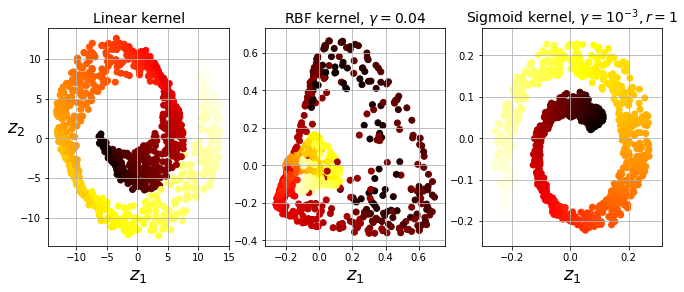

In [20]:
import matplotlib.pyplot as plt

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
    
plt.show()

## 커널 선택과 하이퍼파라미터 튜닝

kPCA는 비지도 학습이기 때문에 좋은 커널과 하이퍼파라미터를 선택하기 위한 명확한 성능 측정 기준이 없다.

하지만 차원 축소는 지도 학습의 전처리 단계로 활용되므로, grid search를 사용해 성능이 좋은 커널과 하이퍼파라미터를 선택할 수 있다.

다음은 kPCA를 사용해 2차원으로 축소하고, 로지스틱 회귀를 사용한 분류를 수행하는 과정에서 `GridSearchCV`를 사용해 가장 좋은 kPCA의 커널과 gamma를 찾는 코드이다.

In [24]:
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ("kpca", KernelPCA(n_components=2)),
    ("log_reg", LogisticRegression())
])

param_grid = [{
    "kpca__gamma" : np.linspace(0.03, 0.05, 10),
    "kpca__kernel" : ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


완전한 비지도 학습으로, 가장 낮은 재구성 오차를 만드는 커널과 하이퍼파라미터를 선택하는 방법도 있지만, 재구성은 쉽지 않다.

아래 그림에서, 커널 트릭을 이용한 kPCA의 결과와 특성 맵(feature map) $\phi$를 사용해 무한차원의 공간으로 매핑한 후, 선형 PCA를 사용해 2D로 투영한 것과 수학적으로 동일하다. (아래 그림에서 오른쪽 위, 아래의 결과가 같다는 의미)

<img src="./images/kernel_pca_and_reconstruction.png" alt="kernel_pca_and_reconstruction">

Reduced space에서 선형 PCA를 역전시키면, 재구성된 데이터 포인트는 원본 공간이 아닌 무한차원의 특성 공간에 놓이게 된다. 무한 차원이므로, 재구성된 포인트를 계산할 수는 없지만 재구성된 포인트에 가깝게 매핑된 원본 공간의 포인트는 찾을 수 있다. 이를 재구성 원상(Reconstruction pre-image)라고 한다.

얻게된 원상과 원본과의 제곱 거리를 통해 재구성 원상의 오차를 최소화 하는 커널과 하이퍼파라미터를 선택할 수 있다.

재구성을 하는 한가지 방법은 투영된 샘플을 훈련 세트로, 원본을 타겟으로 하는 지도 학습 회귀 모델을 학습시키는 것이다.

사이킷런에서는 `fit_inverse_transform=True`를 설정해 이를 수행할 수 있다.

In [25]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                    fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

재구성 원상 오차는 다음과 같이 계산할 수 있다.

In [26]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(X, X_preimage))

32.78630879576614


위 방법을 사용해 grid search를 사용해 오차를 최소화하는 커널과 하이퍼파라미터를 찾을 수 있다.